![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 6 - Convolutional Neural Network</center>
### <center> 2D CNN</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/06_CNN/MainCnn2D.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [4]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib
import torch

For Colab users:

In [5]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/06_CNN/DeepLearningFramework ./DeepLearningFramework
    !pip install torchinfo

In [6]:
#-- Record figures during training:
from DeepLearningFramework.Training import TrainClassficationModel

### Download CIFAR10 dataset:

In [7]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())
lClasses  = oTrainSet.classes
oTrainSet.data.shape

Files already downloaded and verified
Files already downloaded and verified


(50000, 32, 32, 3)

#### Plot some examples:

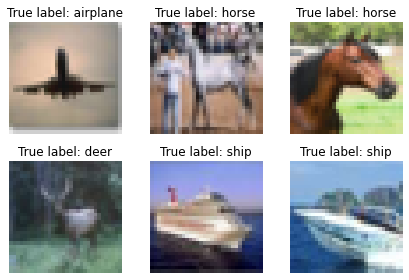

In [12]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(6, 4))
for ax in fig.axes:
    idx   = np.random.randint(N)
    mX, y = oTrainSet[idx]
    ax.imshow   (np.transpose(mX.numpy(), (1,2,0)))
    ax.set_title(f'True label: {lClasses[y]}')
    ax.axis     (False)
    
plt.tight_layout()
plt.show        ()

#### Compute mean and variance:

In [13]:
vMean = oTrainSet.data.mean(axis=(0,1,2)) / 255
vStd  = oTrainSet.data.std (axis=(0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


#### Set datasets with normalization:

In [14]:
oTransform = transforms.Compose([
    transforms.ToTensor (),
    transforms.Normalize(vMean, vStd)
])

oTrainSet.transform = oTransform
oTestSet .transform = oTransform

#### Create data loaders:

In [16]:
batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

mX,       vY       = next(iter(oTrainDL))
mX.shape, vY.shape

(torch.Size([256, 3, 32, 32]), torch.Size([256]))

#### Define the model (2D CNN):

In [17]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchinfo
   
#-- Model:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv2d     (in_channels=3,   out_channels=30,  kernel_size=3, bias=False),
        nn.BatchNorm2d(num_features=30),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
        
        nn.Conv2d     (in_channels=30,  out_channels=60,  kernel_size=3, bias=False),
        nn.MaxPool2d  (kernel_size=2),
        nn.BatchNorm2d(num_features=60),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
                
        nn.Conv2d     (in_channels=60,  out_channels=120, kernel_size=3, bias=False),
        nn.BatchNorm2d(120),
        nn.ReLU(),
        nn.Dropout2d(p=0.2),
        
        nn.Conv2d     (in_channels=120, out_channels=240, kernel_size=3, bias=False),
        nn.BatchNorm2d(240),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
        
        nn.Conv2d     (in_channels=240, out_channels=500, kernel_size=3, bias=False),
        nn.MaxPool2d  (2),
        nn.BatchNorm2d(500),
        nn.ReLU       (),
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten          (),
        nn.Linear           (500, 10),
    )
    
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchinfo.summary(GetModel(), mX.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [256, 3, 32, 32]          --
├─Conv2d: 1-2                            [256, 30, 30, 30]         810
├─BatchNorm2d: 1-3                       [256, 30, 30, 30]         60
├─ReLU: 1-4                              [256, 30, 30, 30]         --
├─Dropout2d: 1-5                         [256, 30, 30, 30]         --
├─Conv2d: 1-6                            [256, 60, 28, 28]         16,200
├─MaxPool2d: 1-7                         [256, 60, 14, 14]         --
├─BatchNorm2d: 1-8                       [256, 60, 14, 14]         120
├─ReLU: 1-9                              [256, 60, 14, 14]         --
├─Dropout2d: 1-10                        [256, 60, 14, 14]         --
├─Conv2d: 1-11                           [256, 120, 12, 12]        64,800
├─BatchNorm2d: 1-12                      [256, 120, 12, 12]        240
├─Re

#### Check whether GPU is available:

In [18]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

#### Train the model:

In [19]:
Loss     = nn.CrossEntropyLoss()
nEpochs  = 30

oModel   = GetModel               ().to(DEVICE)
oOptim   = optim.AdamW            (oModel.parameters(), lr=4e-3, betas=(0.9, 0.99), weight_decay=1e-2)
lHistory = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim)

Epoch 000: | Train loss:  1.694 | Val loss:  1.352 | Train Accuracy:  0.371 | Val Accuracy:  0.512 | epoch time:  6.034 | <-- Checkpoint!
Epoch 001: | Train loss:  1.295 | Val loss:  1.036 | Train Accuracy:  0.534 | Val Accuracy:  0.627 | epoch time:  3.235 | <-- Checkpoint!
Epoch 002: | Train loss:  1.095 | Val loss:  0.934 | Train Accuracy:  0.610 | Val Accuracy:  0.670 | epoch time:  3.221 | <-- Checkpoint!
Epoch 003: | Train loss:  0.968 | Val loss:  0.776 | Train Accuracy:  0.658 | Val Accuracy:  0.734 | epoch time:  3.262 | <-- Checkpoint!
Epoch 004: | Train loss:  0.870 | Val loss:  0.724 | Train Accuracy:  0.692 | Val Accuracy:  0.750 | epoch time:  3.235 | <-- Checkpoint!
Epoch 005: | Train loss:  0.796 | Val loss:  0.692 | Train Accuracy:  0.723 | Val Accuracy:  0.762 | epoch time:  3.244 | <-- Checkpoint!
Epoch 006: | Train loss:  0.737 | Val loss:  0.631 | Train Accuracy:  0.741 | Val Accuracy:  0.788 | epoch time:  3.223 | <-- Checkpoint!
Epoch 007: | Train loss:  0.694 | 

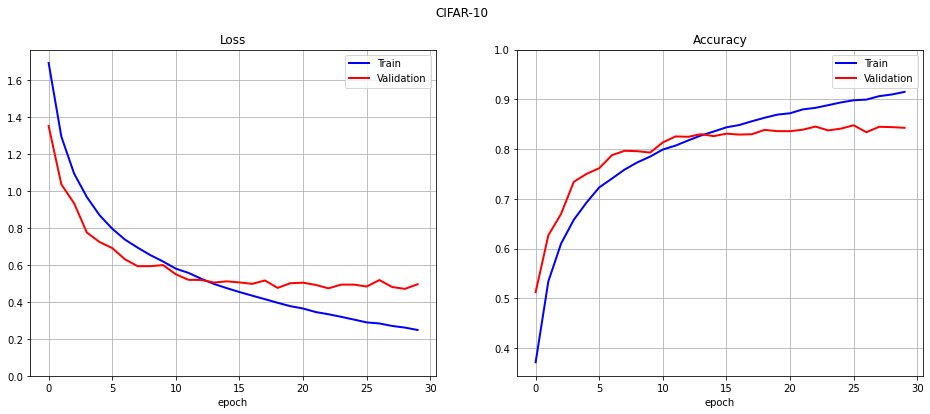

In [20]:
from DeepLearningFramework.Utils import PlotHistory

PlotHistory (lHistory)
plt.suptitle('CIFAR-10')
plt.show    ()

### Exercise
* Load the Fashion-MNIST dataset.
* Use 2D CNN, try to get the high accuracy (above 92% is good).

In [22]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.FashionMNIST(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape

torch.Size([60000, 28, 28])

In [23]:
lClasses  = oTrainSet.classes
lClasses

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

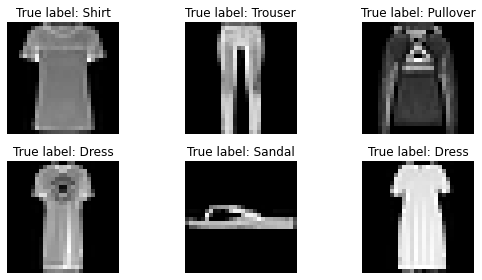

In [24]:
N, H, W = oTrainSet.data.shape
fig, _  = plt.subplots(2, 3, figsize=(8, 4))
for ax in fig.axes:
    idx   = np.random.randint(N)
    mX, y = oTrainSet[idx]
    ax.imshow   (mX.squeeze(), cmap='gray')
    ax.set_title(f'True label: {lClasses[y]}')
    ax.axis     (False)
    
plt.tight_layout()
plt.show()

In [25]:
???

Object `?` not found.


In [26]:
???

Object `??` not found.


In [14]:
???

Epoch 000: | Train loss:  0.621 | Val loss:  0.416 | Train Accuracy:  0.773 | Val Accuracy:  0.851 | epoch time:  4.504 | <-- Checkpoint!
Epoch 001: | Train loss:  0.383 | Val loss:  0.321 | Train Accuracy:  0.862 | Val Accuracy:  0.883 | epoch time:  3.033 | <-- Checkpoint!
Epoch 002: | Train loss:  0.320 | Val loss:  0.310 | Train Accuracy:  0.884 | Val Accuracy:  0.890 | epoch time:  2.861 | <-- Checkpoint!
Epoch 003: | Train loss:  0.290 | Val loss:  0.282 | Train Accuracy:  0.895 | Val Accuracy:  0.894 | epoch time:  2.798 | <-- Checkpoint!
Epoch 004: | Train loss:  0.268 | Val loss:  0.272 | Train Accuracy:  0.902 | Val Accuracy:  0.901 | epoch time:  2.830 | <-- Checkpoint!
Epoch 005: | Train loss:  0.252 | Val loss:  0.252 | Train Accuracy:  0.909 | Val Accuracy:  0.909 | epoch time:  2.773 | <-- Checkpoint!
Epoch 006: | Train loss:  0.236 | Val loss:  0.243 | Train Accuracy:  0.915 | Val Accuracy:  0.910 | epoch time:  2.788 | <-- Checkpoint!
Epoch 007: | Train loss:  0.223 | 

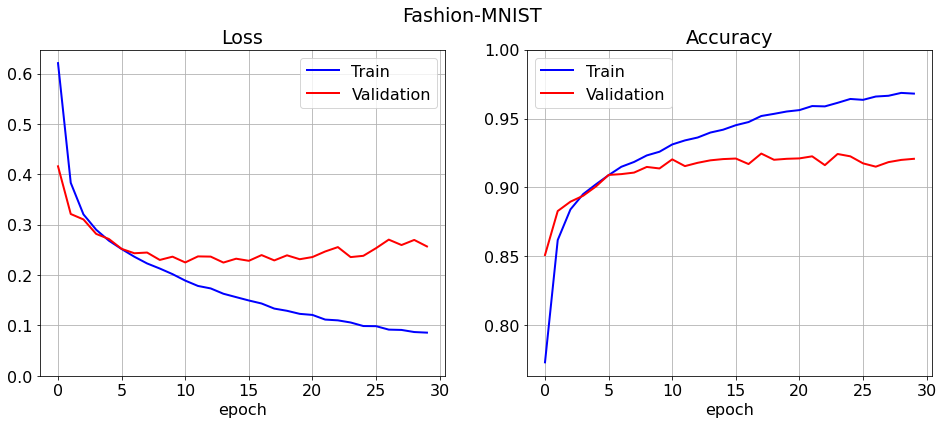

In [15]:
from DeepLearningFramework.Utils import PlotHistory

PlotHistory (lHistory)
plt.suptitle('Fashion-MNIST')
plt.show    ()